In [ ]:
import logging
import os, sys
from pathlib import Path 
from typing import Dict, List 
import json
from omegaconf import OmegaConf,DictConfig
from hydra.core.hydra_config import HydraConfig
import pandas as pd 

from quvine.data.data_loader import load_graph, load_gwas_data
from quvine.data.prepare import PrepareGraphConfig, prepare_graph
from quvine.views.generator import ViewBuilder
from quvine.walks.base import BaseWalker
from quvine.corpus.builder import CorpusBuilder
from quvine.embedding.word2vec import corpus_to_embedding
from quvine.embedding.registry import EmbeddingStore
from quvine.analysis.compare import compare_embeddings
from quvine.analysis.analyze import *
from quvine.baselines import run_node2vec
from quvine.fusion.fuse import fuse_embeddings
from quvine.evaluation.ranking import (
    seed_centroid_scores,
    max_seed_cosine_scores,
    evaluate_embeddings_ranking
    )   
#from quvine.evals.ranking import evaluate_ranking
# from utils.io import save_embeddings, save_metadata 
from quvine.utils.seed import set_global_seed
from quvine.utils.utilities import *
from joblib import Parallel, delayed
import hashlib


In [2]:
path = '/dccstor/boseukb/Q/NetMed/Aug21/GWAS_NetworkPropagation/processed_data/networks/'
network_files = {
    "BioPlex3": path+"BioPlex3_shared/edges_list_ncbi.csv",
    "HumanNet": path+"HumanNetV3/edges_list_ncbi.csv",
    "PCNet": path+"PCNet/edges_list_ncbi.csv",
    "ProteomeHD": path+"ProteomeHD/edges_list_ncbi.csv",
    "STRING": path+"STRING/edges_list_ncbi.csv",
}

networks = ['ProteomeHD','BioPlex3','STRING','HumanNet','PCNet']
diseases = ['asthma','autism','schizophrenia']

In [3]:
from omegaconf import OmegaConf

cfg = OmegaConf.create({
    "data_path": "/dccstor/boseukb/Q/NetMed/Aug21/GWAS_NetworkPropagation/processed_data",

    "graph": {
        "name": "ProteomeHD",
        "path": "../Aug21/GWAS_NetworkPropagation/processed_data/networks/ProteomeHD/edges_list_ncbi.csv",
    },

    "disease": {
        "name": "schizophrenia",
    },

    "runtime": {
        "name": "qune",
        # originally: ${now:%Y-%m-%d_%H-%M-%S}
        # notebook-safe placeholder
        "run_name": "manual_run",
        "run_dir": "../../outputs/",
        "n_jobs": 1,
        "chunk_size": 1
    },

    "experiment": {
        "iterations": 2,
        "base_seed": 42,
    },

    "seed": 42,

    "draw": {
        "graph": True,
        "verbose": False,
    },

    "preprocess": {
        "subsample": {
            "enabled": True,
            "max_nodes": 500,
            "radius": 3,
        },
        "sparsify": {
            "enabled": True,
            "retain_ratio": 0.7,
            "max_degree": 40,
            "scoring": 'common_neighbors'
        },
    },

    "verbose": True,
    "plots": True,

    "views": {
        "num_views": 8,
        "constrained": True,
        "max_degree": 6,
        "max_nodes": 60,
        "max_edges": 180
    },

    "walks": {
        "kinds": ["rwr", "ctqw", "dtqw"],
        "num_walks": 10,
        "walk_length": 10,
        "restart_prob": 0.35,
        "steps": 18,
        "time": 1.2,
        "coin": "grover",
        "max_iter": 1000,
    },

    # --------------------
    # shared hyperparameters
    # --------------------
    "dimension": 64,
    "window": 5,
    "min_count": 1,
    "workers": 8,

    "train": {
        "embedding_dim": 64,
        "window": 5,
        "sg": 1,
        "negative": 10,
        "workers": 8,
        "min_count": 1,
        "epochs": 100,
    },

    "baselines": {
        "node2vec": {
            "enabled": True,
            "dimensions": 64,
            "walk_length": 8,
            "num_walks": 10,
            "p": 1,
            "q": 0.5,
            "window": 5,
            "min_count": 1,
            "workers": 8,
            "seed": 42,
        },
    },

    "fusion": {
        "enabled": True,
        "method": "all",
        "k": 25,
    },

    "analysis": {
        "cca_components": 10,
        "knn_k": 5,
    },

    "eval": {
        "k_values": [20, 40, 80],
        "n_repeats": 20,
        "deg_tol": 0.1,
        "centroid": False, 
        "max_seed": True
    },
})


In [4]:
def load_giant(network):
    """
    Loads the largest connected component (giant component) of a network from a CSV file.

    """
    df = pd.read_csv(network_files[network], dtype={'node1': str, 'node2': str})[["node1", "node2"]]
    graph = nx.from_pandas_edgelist(df, source="node1", target="node2")
    # Find the largest connected component in the graph
    giant = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(giant)
    
    return graph

def get_stats(G): 
    stats = {}
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    stats['num_connected_components'] = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    stats['largest_cc_size'] = len(largest_cc)
    stats['average_clustering_coefficient'] = nx.average_clustering(G)
    degrees = [d for n, d in G.degree()]
    stats['average_degree'] = np.mean(degrees)
    stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(G)
    betweenness = list(nx.betweenness_centrality(G).values())
    stats['average_clustering_coefficient'] = np.mean(betweenness)
    
    return stats

def draw_graph(G, source=None, target=None, title="Graph"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    default_color = "#185e8d"
    d = dict(G.degree())
    node_colors = [default_color] * len(G.nodes)
    node_to_index = {node:i for i, node in enumerate(G.nodes)}
    if source is None and target is None:
        nx.draw_networkx(G, 
                pos = pos, 
                with_labels=True,
                nodelist=list(d.keys()), 
                node_color=node_colors,
                node_size=[v*6 for v in d.values()],
                width=2)
    else: 
        for s,t in zip(source, target):
            for i, node in enumerate([s,t]): 
                if node in node_to_index:
                    if i == 0:
                        node_colors[node_to_index[node]] = 'red'
                    elif i == 1: 
                        node_colors[node_to_index[node]] = 'green'
                else:
                    print(f"Node {node} not found in graph")
        nx.draw_networkx(G, 
                pos = pos, 
                with_labels=False,
                nodelist=list(d.keys()), 
                node_color=node_colors,
                node_size=[v*6 for v in d.values()],
                width=2)
    plt.title(title)
    plt.show()

def set_iteration_seed(cfg, it):
    seed = cfg.seed + it
    set_global_seed(seed)
    
def build_views(cfg, graph_data, root, rng):
        
    view_gen = ViewBuilder(cfg=cfg, rng=rng)
    return view_gen.build(graph_data, root)
    
def run_walks_for_root(cfg, graph_data, root, views, rng): 
    
    walker = BaseWalker(cfg=cfg, rng=rng)
    all_walks = {k: [] for k in cfg.walks.kinds}
    
    for view in views: 
        #induce subgraph 
        view_g = graph_data.subgraph(view)
        view_nodes = list(view_g.nodes())
        
        if len(view_nodes) < 2: 
            continue 
        if view_g.number_of_edges() == 0:
            continue 
        
        #run walker once per view 
        out = walker.run(graph_data, root, view_nodes)
        
        for walk_kind, walks in out.items(): 
            all_walks[walk_kind].extend(walks)
    
    return all_walks

def corpus_hash(corpus):
        s = " ".join(",".join(w) for w in corpus[:100])
        return hashlib.md5(s.encode()).hexdigest()

def train_embeddings(cfg, graph_data, all_corpora):
    embeddings = {} 
    node_list = list(graph_data.nodes)
    
    
    for kind, corpus in all_corpora.items(): 
                
        Z = corpus_to_embedding(
                                corpus=corpus, 
                                nodes=node_list,
                                vector_size=cfg.train.embedding_dim, 
                                window=cfg.train.window,
                                sg=cfg.train.sg, 
                                negative=cfg.train.negative, 
                                min_count=cfg.min_count,
                                workers=cfg.train.workers, 
                                epochs=cfg.train.epochs
                                )
        
        embeddings[kind] = Z
    
    return embeddings

def chunkify(seq, chunk_size): 
    for i in range(0, len(seq, chunk_size)): 
        yield seq[i:i + chunk_size]
    
def process_root(graph_data, root, node2idx, it): 
        
        idx = node2idx[root]
        seed = (cfg.experiment.base_seed + 10000 * it + idx)
        rng = np.random.default_rng(seed)
        
        views = build_views(cfg, graph_data, root, rng) 
        walk_outputs = run_walks_for_root(cfg, graph_data, root, views, rng) 
        
        if not walk_outputs or all(len(walks) == 0 for walks in walk_outputs.values()):
            return root, {}   # or mark as invalid
        else:
            return root, walk_outputs

def process_root_chunk(graph_data, roots, node2idx, it):
    """
    Process a batch of roots inside a single worker process.
    Returns a list of (root, walk_outputs).
    """
    results = []

    for root in roots:
        root, walk_outputs = process_root(graph_data, root, node2idx, it)
        results.append((root, walk_outputs))

    return results     

def raw_diff(A, B, nameA="A", nameB="B"):
    import numpy as np
    print(nameA, nameB)
    print("  max|diff|:", float(np.max(np.abs(A - B))))
    print("  mean|diff|:", float(np.mean(np.abs(A - B))))
    print("  allclose:", bool(np.allclose(A, B, atol=1e-12, rtol=0)))

def run_single_iteration(cfg, it, graph_data, source, target):
    
    
    # setup 
    roots = list(graph_data.nodes)
    node2idx = {node: i for i, node in enumerate(sorted(roots))}
    
    corpus_builder = {kind: CorpusBuilder()
                    for kind in cfg.walks.kinds}
    
    # decide serial vs parallel 
    n_roots = len(roots)
    if n_roots < 2000 or cfg.runtime.n_jobs == 1: 
        chunks = [roots]
        n_jobs = 1 
    else: 
        chunk_size = cfg.runtime.chunk_size 
        chunks = list(chunkify(roots, chunk_size))
        n_jobs = cfg.runtime.n_jobs 
        
    parallel = Parallel(n_jobs=n_jobs, 
                        backend='loky', 
                        batch_size=1, 
                        prefer='processes'
                        )
    
    valid_roots = 0
    nodeset = set(graph_data.nodes)
    
    for chunk_results in parallel(
        delayed(process_root_chunk)(graph_data, chunk, node2idx, it)
        for chunk in chunks
        ):
        
        for root, walk_outputs in chunk_results: 
            if not walk_outputs or all(len(w)==0 for w in walk_outputs.values()):
                continue 
            valid_roots +=1 
            
            for walk_kind, walks in walk_outputs.items(): 
                if len(walks) == 0: 
                    continue 
                for w in walks:
                    for t in w:
                        assert t in nodeset, (
                            f"[{walk_kind}] invalid token {t} "
                            f"(root={root})"
                        )
                corpus_builder[walk_kind].add(root, walks)
                
    
    assert valid_roots > 0, "No valid roots with walks were found."
    
    all_corpora = {kind: builder.build() 
                for kind, builder in corpus_builder.items()}
    
    for kind, corpus in all_corpora.items():
        toks = {t for w in corpus for t in w}
        nodes = set(graph_data.nodes)
        assert toks <= nodes, f"{kind}: corpus contains non-node tokens!"
        
    # for k,c in all_corpora.items():
    #         print(k, corpus_hash(c))
    
    embeddings = train_embeddings(cfg, graph_data, all_corpora)
    
    store = EmbeddingStore()
    for name, Z in embeddings.items():
        store.add(name, Z)
        
    # compare embeddings 
    comparison_metrics = compare_embeddings(
                                    store,
                                    cca_components=cfg.analysis.cca_components,
                                    knn_k=cfg.analysis.knn_k,
                                    )

    ## fuse embeddings
    if cfg.fusion.enabled:
        L = nx.normalized_laplacian_matrix(G=graph_data, 
                                    nodelist=graph_data.nodes).toarray().astype(np.float32)
        
        fused_list, fuse_metric = fuse_embeddings(
            store,
            method=cfg.fusion.method,
            k=cfg.fusion.k, 
            L=L
        )
        
        for i, Z_fused in enumerate(fused_list): 
            store.add(fuse_metric[i], Z_fused)
    
    
    if cfg.baselines.node2vec.enabled:
        Z_n2v = run_node2vec(
                    graph=graph_data,
                    nodes=graph_data.nodes,
                    dimensions=cfg.baselines.node2vec.dimensions,
                    walk_length=cfg.baselines.node2vec.walk_length,
                    num_walks=cfg.baselines.node2vec.num_walks,
                    p=cfg.baselines.node2vec.p,
                    q=cfg.baselines.node2vec.q,
                    window=cfg.baselines.node2vec.window,
                    min_count=cfg.baselines.node2vec.min_count,
                    workers=cfg.baselines.node2vec.workers,
                    seed=cfg.baselines.node2vec.seed
                    )
        store.add("node2vec", Z_n2v)
        
    
    seed_indices = [
        i for i, node in enumerate(graph_data.nodes)
        if node in source
    ]

    scores_by_method = {}

    for name, Z in store.items():
        if cfg.eval.centroid:
            scores_by_method[f"{name}_centroid"] = seed_centroid_scores(
                Z, seed_indices
            )
        if cfg.eval.max_seed:
            scores_by_method[f"{name}_max"] = max_seed_cosine_scores(
                Z, seed_indices
            )
            
    ranking_df = evaluate_embeddings_ranking(
        scores_by_method=scores_by_method,
        subgraph=graph_data,
        seeds=source,
        targets=target,
        nodes=graph_data.nodes,
        k_values=cfg.eval.k_values,
        n_repeats=cfg.eval.n_repeats,
        deg_tol=cfg.eval.deg_tol,
        iteration=it,
    )
    # standard metadata for analysis 
    
    return {
            "iteration": it,
            "ranking_df": ranking_df,
            "comparison": comparison_metrics,
        }

def post_process(all_results):
        
    ranking_dfs = [
                    r["ranking_df"] for r in all_results
                    if r["ranking_df"] is not None
                ]   

    ranking_results_df = pd.concat(
        ranking_dfs,
        ignore_index=True
    )
    
    comparison_rows = []

    for r in all_results:
        it = r["iteration"]
        for pair, metrics in r["comparison"].items():
            for name, value in metrics.items():
                comparison_rows.append({
                    "iteration": it,
                    "pair": pair,
                    "metric": name,
                    "value": value,
                })

    comparison_df = pd.DataFrame(comparison_rows)


    return ranking_results_df, comparison_df

def plot_all(cfg, ranking_df, out_dir):
        
        plot_metric(cfg=cfg, 
                        df=ranking_df, 
                        metric='recall', 
                        file_path=out_dir)
        plot_metric(cfg=cfg, 
                    df=ranking_df, 
                    metric='precision', 
                    file_path=out_dir)
        
        plot_precision_recall(df=ranking_df, 
                            control='true', 
                            file_path=out_dir)
        plot_precision_recall(df=ranking_df, 
                            control='degree_matched', 
                            file_path=out_dir)
        plot_precision_recall(df=ranking_df, 
                            control='distance_matched', 
                            file_path=out_dir)
        
        plot_metric_vs_k(df=ranking_df, 
                        metric='recall',
                        control='true',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='precision',
                        control='true',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='recall',
                        control='degree_matched',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='precision',
                        control='degree_matched',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='recall',
                        control='distance_matched',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='precision',
                        control='distance_matched',
                        file_path=out_dir)
        

In [5]:
stats_dict = {}
network = cfg.graph.name
graph = load_giant(network) 
print(f"Network: {network}")
stats_dict[network] = get_stats(graph)
print(stats_dict)

Network: ProteomeHD
{'ProteomeHD': {'num_nodes': 2471, 'num_edges': 62598, 'density': 0.020512602054274933, 'num_connected_components': 1, 'largest_cc_size': 2471, 'average_clustering_coefficient': 0.0014310752143462061, 'average_degree': 50.666127074059084, 'degree_assortativity_coefficient': 0.31202246925157145}}


In [6]:
source, target = load_gwas_data(cfg, graph)

cfg_pg = PrepareGraphConfig(
    subsample_nodes=cfg.preprocess.subsample.enabled, 
    max_nodes=cfg.preprocess.subsample.max_nodes, 
    radius=cfg.preprocess.subsample.radius,
    sparsify_edges=cfg.preprocess.sparsify.enabled,
    retain_ratio=cfg.preprocess.sparsify.retain_ratio,
    max_degree=cfg.preprocess.sparsify.max_degree,
    scoring=cfg.preprocess.sparsify.scoring,
    verbose=cfg.verbose
)

graph_data = prepare_graph(cfg_pg,
                        graph=graph, 
                        seeds=source, 
                        targets=target, 
                        seed=cfg.seed
                        )


Number of seed genes: 49, and target genes: 78
--------------------------------------------------
After prepare_graph()
Nodes: 456
Edges: 5617
Avg degree: 24.64
Max degree: 40
--------------------------------------------------


In [7]:
print(f"Seed genes: {len(source)}, targets: {len(target)}") 
print(get_stats(graph_data))

Seed genes: 49, targets: 78
{'num_nodes': 456, 'num_edges': 5617, 'density': 0.054144977829188354, 'num_connected_components': 1, 'largest_cc_size': 456, 'average_clustering_coefficient': 0.006895479124785871, 'average_degree': 24.635964912280702, 'degree_assortativity_coefficient': 0.6145092714344494}


Node 7385 not found in graph
Node 8968 not found in graph
Node 10643 not found in graph
Node 55843 not found in graph
Node 11344 not found in graph
Node 9277 not found in graph
Node 11311 not found in graph
Node 6789 not found in graph
Node 9640 not found in graph
Node 9793 not found in graph
Node 11344 not found in graph
Node 374659 not found in graph
Node 60412 not found in graph
Node 8520 not found in graph
Node 2783 not found in graph
Node 64146 not found in graph
Node 9553 not found in graph
Node 23310 not found in graph
Node 54808 not found in graph
Node 9640 not found in graph
Node 493856 not found in graph
Node 10953 not found in graph
Node 80222 not found in graph
Node 8379 not found in graph
Node 54853 not found in graph
Node 286077 not found in graph


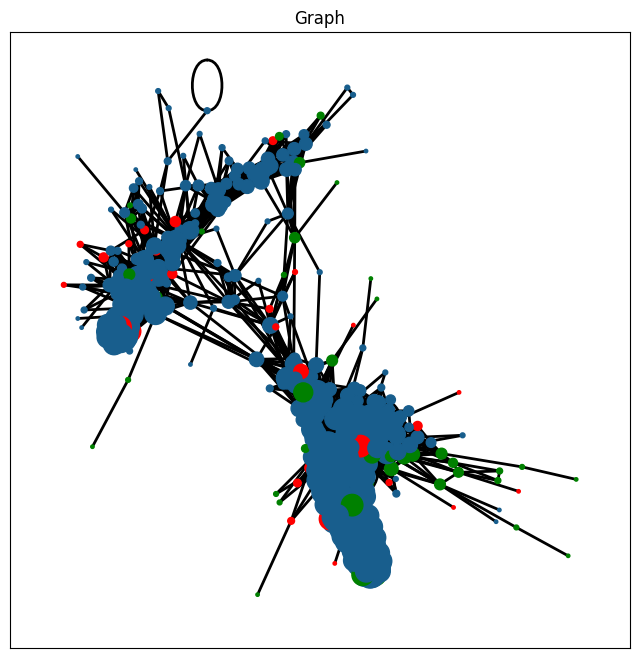

In [8]:
draw_graph(G=graph_data, source=source, target=target) 

In [9]:
n_iters = cfg.experiment.iterations
all_results = []
for it in range(n_iters):
    print(f"Iteration {it+1}/{n_iters}")
    set_iteration_seed(cfg, it)

    import traceback 
    try:
        res = run_single_iteration(cfg, it, graph_data, source, target)
    except Exception:
        traceback.print_exc(limit=50)
        raise 
    
    all_results.append(res)
    
ranking_df, comparison_df = post_process(all_results)


Iteration 1/2


Computing transition probabilities:   0%|          | 0/456 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 66.81it/s]


Iteration 2/2


Computing transition probabilities:   0%|          | 0/456 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 74.76it/s]


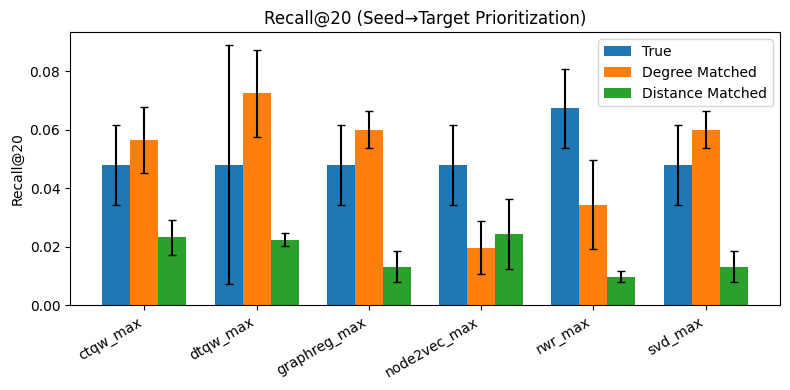

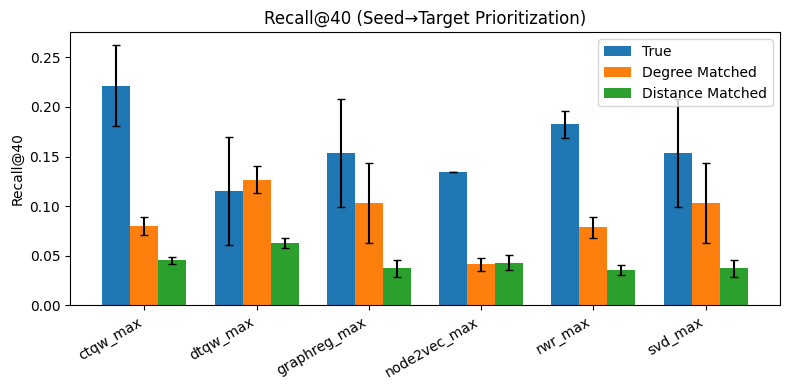

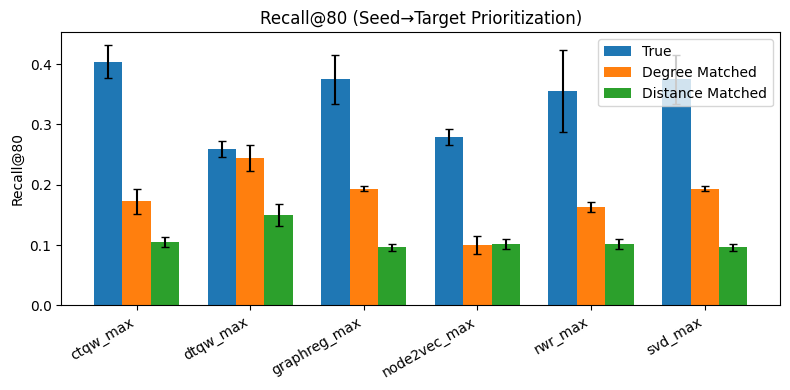

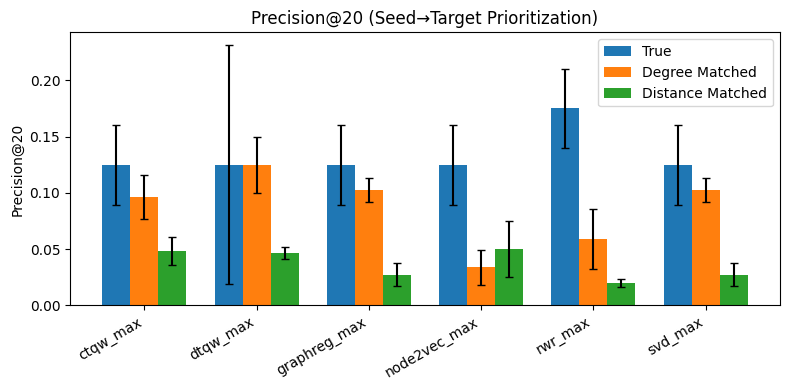

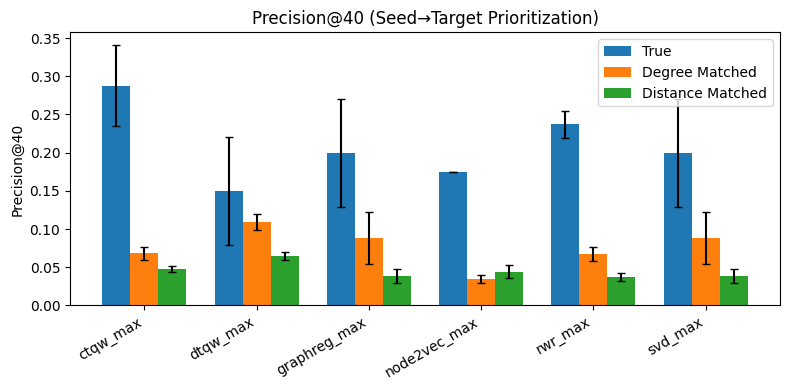

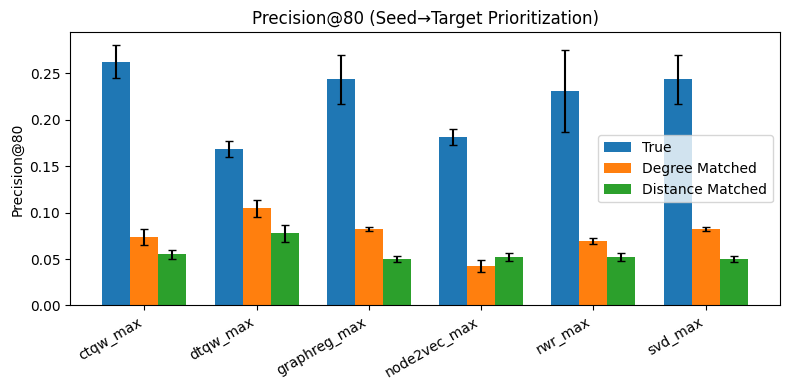

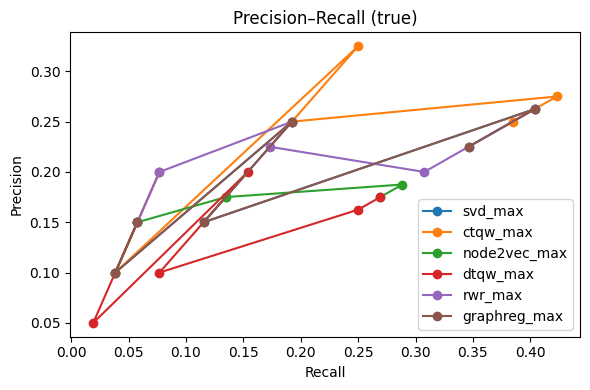

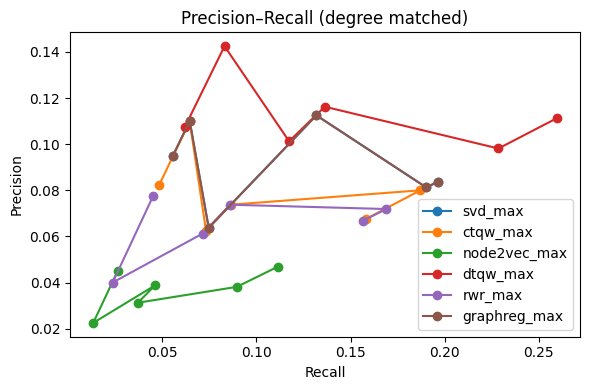

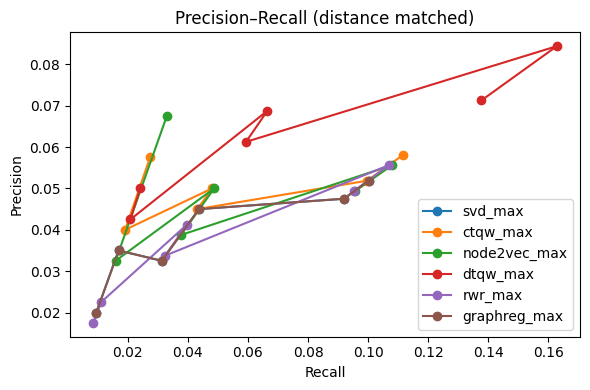

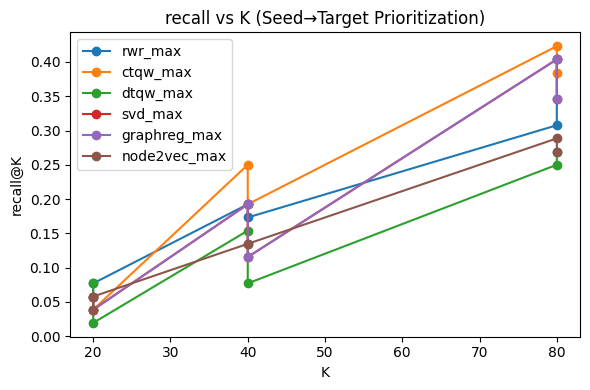

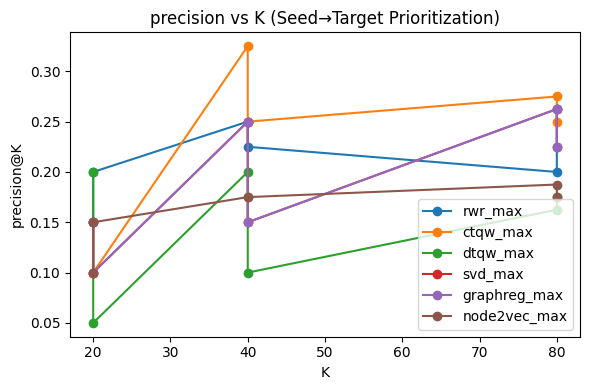

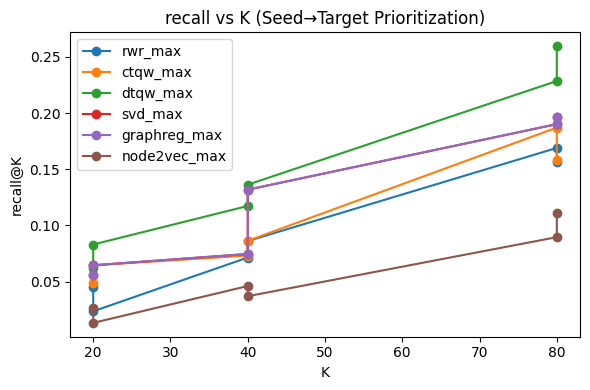

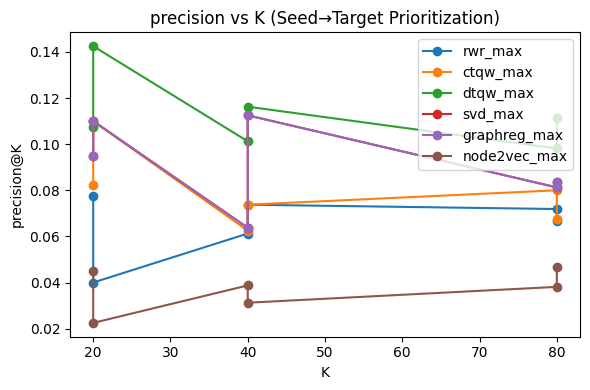

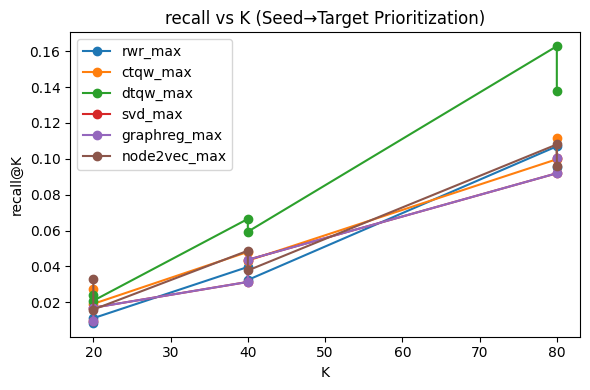

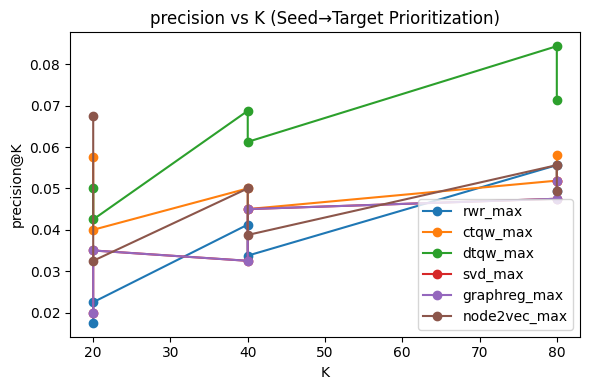

In [10]:
plot_all(cfg, ranking_df, out_dir=cfg.runtime.run_dir)